## Analysis on the trained CT encoder models

In [2]:
import deepSI
from deepSI import System_data, System_data_list
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from tqdm.auto import tqdm
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import os
import pickle

f_norms_num = np.geomspace(0.0001, 10, num=21)

In [12]:
def get_train_val_test(dataset):
    if dataset=='CED':
        data_full = deepSI.datasets.CED()
        train = System_data_list([data_i[:300] for data_i in data_full])
        test = System_data_list([data_i[300:] for data_i in data_full])
        val = System_data_list([t[:100] for t in test])
    elif dataset=='CCT':
        train, test = deepSI.datasets.Cascaded_Tanks()
        val, test = test[:len(test)//2], test
    return train, val, test


def load_data(dataset, load=True):
    file_name = f'./encoder-model-analysis-results/re_ordered-f_norms-{dataset}'
    if load and os.path.exists(file_name):
        return pickle.load(open(file_name,'rb'))
    
    train, val, test = get_train_val_test(dataset)
    dir_name = f'./models-encoder-CT-{dataset}/'

    sys_names = [dir_name + f for f in os.listdir(dir_name)]
    sys_names = sorted(sys_names,key=lambda x: x.split('-')[2])
    outputs = []
    for name in tqdm(sys_names):
        if 'best' not in name:
            continue
        print(name,end=' ')
        d = dict()
        outputs.append(d)
        sys = deepSI.load_system(name)
        name = name.split('/')[-1]
        d['name'] = name
        if 'con' in name:
            d['type'] = 'con'
            d['f_norm'] = name.split('-')[-2] #is a str
        else:
            d['type'] = 'dis'
        test_p = sys.apply_experiment(test,save_state=True)
        d['test_p'] = test_p
        d['NRMS'] = test_p.NRMS(test)
        d['RMS'] = test_p.RMS(test)
        if isinstance(test_p,System_data_list):
            X = np.concatenate([ti.x[ti.cheat_n:] for ti in test_p],axis=0)
            U = np.concatenate([ti.u[ti.cheat_n:] for ti in sys.norm.transform(test_p)],axis=0)
        else:
            X = test_p.x[test_p.cheat_n:]
            U = sys.norm.transform(test_p).u[test_p.cheat_n:]
        
        xamp = np.mean(np.mean(X**2,axis=1))**0.5 #np.mean(np.sum(X**2,axis=1)**0.5)
        d['|x|'] = 100 if np.isnan(xamp) else xamp
        
        if d['type']=='con':
            with torch.no_grad():
                fxu = sys.fn.deriv_base(torch.as_tensor(X,dtype=torch.float32),torch.as_tensor(U,dtype=torch.float32)).numpy()
                d['|f|'] = np.mean(np.mean(fxu**2,axis=1))**0.5
        else:
            d['|f|'] = None

    f_norms = set([o.get('f_norm') for o in outputs if o.get('f_norm') is not None])
    f_norms = sorted(f_norms,key=lambda x: float(x))

    from collections import defaultdict
    re_ordered = defaultdict(list)
    print(re_ordered)
    for d in outputs:
        for f_norm in f_norms:
            if d['type']=='con' and d['f_norm']==f_norm:
                re_ordered[f_norm].append(d)

    for d in outputs:
        if d['type']=='dis':
            re_ordered['dis'].append(d)
    
    out = re_ordered, f_norms
    pickle.dump(out, open(file_name, 'wb'))
    return out
    
def get_lyapunov(dataset,load=True):
    file_name = f'./encoder-model-analysis-results/lyap-{dataset}'
    if load and os.path.exists(file_name):
        return pickle.load(open(file_name,'rb'))

    train, val, test = get_train_val_test(dataset)

    out = [(i,deepSI.load_system(f'./models-encoder-CT-{dataset}/dis-{i}-best').apply_experiment(test).NRMS(test)) \
           for i in range(500) if os.path.exists(f'./models-encoder-CT-{dataset}/dis-{i}-best')]
    print(out)
    ibest = min(out, key=lambda x: x[1])[0]
    sys = deepSI.load_system(f'./models-encoder-CT-{dataset}/dis-{ibest}-best')

    test.plot()
    sys.apply_experiment(test).plot()
    plt.legend(['test','test sim'])
    plt.show()

    from deepSI.utils import get_lyapunov_exponent
    dt_lyapunov = get_lyapunov_exponent(sys, test[0] if isinstance(test, System_data_list) else test)
    dis_lyapunov = np.exp(dt_lyapunov)
    tau_dt = -1/dt_lyapunov
    
    print('dt_lyapunov=',dt_lyapunov)
    print('dis_lyapunov=',dis_lyapunov)
    print('tau_dt=',tau_dt)

    out = dt_lyapunov, dis_lyapunov, tau_dt
    pickle.dump(out, open(file_name, 'wb'))
    return out

    
def full_analysis(dataset,load=True):
    train, val, test = get_train_val_test(dataset)
    
    re_ordered, f_norms = load_data(dataset,load=load)
    dt_lyapunov, dis_lyapunov, tau_dt = get_lyapunov(dataset,load=load)
    

    f_norm = f_norms[0]
    names = f_norms + ['dis']
    NRMS_data = [[z['NRMS'] for z in re_ordered[name]] for name in names]
    NRMS_data = [[2 if np.isnan(zi) else zi for zi in z] for z in NRMS_data]

    RMS_data = [[z['RMS'] for z in re_ordered[name]] for name in names]
    RMS_data = [[10. if np.isnan(zi) else zi for zi in z] for z in RMS_data]
    
    ampx_data = [[z['|x|'] for z in re_ordered[name]] for name in names]
    ampf_data = [[z['|f|'] for z in re_ordered[name]] for name in names]
    ampf_data[-1] = []
    
    return RMS_data, NRMS_data, ampx_data, ampf_data, names, dt_lyapunov, re_ordered, train, test, val

def visualize(NRMS_data,ampx_data,ampf_data,names,dt_lyapunov,ylims=[(0.1,1.0),(0.4,6),(0.1,10)]):
    best_id = np.argmin([np.median(z) for z in NRMS_data])
    for data,ylabel,ylims,hline in zip([NRMS_data,ampx_data,ampf_data],\
                                 ['NRMS','|x|','|f|'],\
                                 ylims,\
                                 [False, True, True]):

        lap_id = np.log(-dt_lyapunov/f_norms_num[0])/np.log(f_norms_num[1]/f_norms_num[0])
        plt.figure(figsize=(19,4))
        plt.boxplot(data,labels=names)
        plt.ylim(*ylims)
        plt.ylabel(ylabel)
        plt.vlines([lap_id],[ylims[0]],[ylims[1]],'r')

        plt.vlines([best_id+1],[ylims[0]],[ylims[1]],'k')
        xlim = plt.xlim()
        if hline:
            plt.hlines([1.0],[xlim[0]],[xlim[1]])
            plt.xlim(*xlim)
        plt.ylim(*ylims)
        plt.semilogy()
        plt.grid()
        plt.show()


def box_plots(NRMS_data,ampx_data,ampf_data,names,dt_lyapunov,dataset,ylims=[(0.1,1.0),(0.1,10)],title=''):
    ampf_data = [np.array(z)[np.isfinite(z)] for z in ampf_data]
    
    z = 0.8
    plt.figure(figsize=(9*z,3.5*z))
    
    xmeans = [np.median(z) for z in ampx_data]
    lap_id = np.log(-dt_lyapunov/f_norms_num[0])/np.log(f_norms_num[1]/f_norms_num[0])
    best_id = np.argmin([np.median(z) for z in NRMS_data])
    
    names_small = names[:]
    names_small[1:-1:2] = ['']*len(names_small[1:-1:2])
    names_small[0] = names_small[0][:-1] #manually set the labels for the box plot
    names_small[2] = names_small[2][:-1]
    names_small[4] = names_small[4][:-2]
    names_small[6] = names_small[6][:-2]
    names_small[8] = names_small[8][:-3]
    names_small[10] = names_small[10][:-3]
    names_small[12] = names_small[12][:-4]
    names_small[14] = names_small[14][:-4]
    names_small[16] = names_small[16][0]
    names_small[18] = names_small[18][0]
    names_small[20] = names_small[20][:2]
    
    for i in range(2):
        plt.subplot(2,1,i+1)
        if i==0:
            plt.title(title)
        plt.boxplot(ampf_data if i==0 else NRMS_data,labels=names_small if i==1 else ['']*len(names_small))
        plt.semilogy()
        if i==0:
            plt.plot(np.arange(len(xmeans))+1,xmeans,'o--',label='RMS($x$)')
            plt.legend()
        plt.grid()
        plt.ylim(ylims[1-i])
        
        plt.ylabel(r'RMS($f$)' if i==0 else 'RMSE')
        if i==1:
            plt.xlabel('$\\Delta t/\\tau$')

        ylim = plt.ylim()

        plt.ylim(ylim)
    plt.tight_layout()
    plt.savefig(f'figures-for-paper/box-plot-{dataset}.jpg',dpi=300)
    plt.savefig(f'figures-for-paper/box-plot-{dataset}.png',dpi=300,transparent=True)
    plt.savefig(f'figures-for-paper/box-plot-{dataset}.pdf')
    plt.savefig(f'figures-for-paper/box-plot-{dataset}.svg')
    plt.show()
    
def test_p_plot(names,RMS_data,re_ordered,test,dataset,xlim=(0,300),title=''):
    best_name = min(list(zip(names,RMS_data)),key=lambda x: np.median(x[1]))[0]
    best_data = re_ordered[best_name]
    best_name = '($\\Delta t/\\tau = 0.32$)' if best_name[2]=='3' else '($\\Delta t/\\tau = 0.018$)'
    best_name = 'Models \n' + best_name
    z = 0.8
    
    
    if not isinstance(test,System_data_list): 
        plt.figure(figsize=(9*z,2*z))
        plt.title(title)
        for i,b in enumerate(best_data):
            plt.plot(b['test_p'].y,'r--',alpha=0.7,label=None if i>0 else best_name)
        plt.plot(test.y,'k',label='System')
        plt.legend(loc=(1+0.015,0.0))
        plt.grid()
        plt.xlim(xlim)
        plt.xlabel('Index time')
        plt.ylabel('$y$')
    else:
        plt.figure(figsize=(10*z,2*z))
        axes = [plt.subplot(1,2,1),plt.subplot(1,2,2)]
        for i,b in enumerate(best_data):
            l = 0
            for ax,bi in zip(axes,b['test_p']):
                ax.plot(np.arange(0,len(bi)),bi.y,'r--',alpha=0.7,label=None if (i>0 or l==0) else best_name)
                l += len(bi)
        l = 0
        for ax,ti in zip(axes,test):
            ax.plot(np.arange(0,len(ti)),ti.y,'k',label='System' if l>0 else None)
            l += len(ti)
        axes[0].set_ylabel('$y$')
        axes[0].set_xlabel('Index time')
        axes[1].set_xlabel('Index time')
        axes[0].grid()
        axes[1].grid()
        axes[1].set_yticklabels([''])
        axes[0].set_title('(b.1) CED set 1')
        axes[1].set_title('(b.2) CED set 2')
        axes[0].set_ylim(axes[1].get_ylim())
        plt.legend(loc=(1+0.015,0.0))
    
    plt.tight_layout(pad=0.0)

    
    plt.savefig(f'figures-for-paper/test-p-{dataset}.jpg',dpi=300)
    plt.savefig(f'figures-for-paper/test-p-{dataset}.png',dpi=300,transparent=True)
    plt.savefig(f'figures-for-paper/test-p-{dataset}.svg',transparent=False)
    plt.savefig(f'figures-for-paper/test-p-{dataset}.pdf')
    
    plt.show()


  0%|          | 0/1213 [00:00<?, ?it/s]

./models-encoder-CT-CED/con-0-0.00010-best ./models-encoder-CT-CED/con-0-0.00018-best ./models-encoder-CT-CED/con-0-0.00032-best ./models-encoder-CT-CED/con-0-0.00056-best ./models-encoder-CT-CED/con-0-0.00100-best ./models-encoder-CT-CED/con-0-0.00178-best ./models-encoder-CT-CED/con-0-0.00316-best ./models-encoder-CT-CED/con-0-0.00562-best ./models-encoder-CT-CED/con-0-0.01000-best ./models-encoder-CT-CED/con-0-0.01778-best ./models-encoder-CT-CED/con-0-0.03162-best ./models-encoder-CT-CED/con-0-0.05623-best ./models-encoder-CT-CED/con-0-0.10000-best ./models-encoder-CT-CED/con-0-0.17783-best ./models-encoder-CT-CED/con-0-0.31623-best ./models-encoder-CT-CED/con-0-0.56234-best ./models-encoder-CT-CED/con-0-1.00000-best ./models-encoder-CT-CED/con-0-1.77828-best ./models-encoder-CT-CED/con-0-10.00000-best 

<ipython-input-12-08ec62d10308>:49: RuntimeWarning: overflow encountered in square
  xamp = np.mean(np.mean(X**2,axis=1))**0.5 #np.mean(np.sum(X**2,axis=1)**0.5)
D:\Programs\anaconda3\lib\site-packages\numpy\core\_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
<ipython-input-12-08ec62d10308>:55: RuntimeWarning: overflow encountered in square
  d['|f|'] = np.mean(np.mean(fxu**2,axis=1))**0.5


./models-encoder-CT-CED/con-0-3.16228-best ./models-encoder-CT-CED/con-0-5.62341-best ./models-encoder-CT-CED/con-1-0.00010-best ./models-encoder-CT-CED/con-1-0.00018-best ./models-encoder-CT-CED/con-1-0.00032-best ./models-encoder-CT-CED/con-1-0.00056-best ./models-encoder-CT-CED/con-1-0.00100-best ./models-encoder-CT-CED/con-1-0.00178-best ./models-encoder-CT-CED/con-1-0.00316-best ./models-encoder-CT-CED/con-1-0.00562-best ./models-encoder-CT-CED/con-1-0.01000-best ./models-encoder-CT-CED/con-1-0.01778-best ./models-encoder-CT-CED/con-1-0.03162-best ./models-encoder-CT-CED/con-1-0.05623-best ./models-encoder-CT-CED/con-1-0.10000-best ./models-encoder-CT-CED/con-1-0.17783-best ./models-encoder-CT-CED/con-1-0.31623-best ./models-encoder-CT-CED/con-1-0.56234-best ./models-encoder-CT-CED/con-1-1.00000-best ./models-encoder-CT-CED/con-1-1.77828-best ./models-encoder-CT-CED/con-1-10.00000-best ./models-encoder-CT-CED/con-1-3.16228-best ./models-encoder-CT-CED/con-1-5.62341-best ./models-e

./models-encoder-CT-CED/con-20-3.16228-best ./models-encoder-CT-CED/con-20-5.62341-best ./models-encoder-CT-CED/con-21-0.00010-best ./models-encoder-CT-CED/con-21-0.00018-best ./models-encoder-CT-CED/con-21-0.00032-best ./models-encoder-CT-CED/con-21-0.00056-best ./models-encoder-CT-CED/con-21-0.00100-best ./models-encoder-CT-CED/con-21-0.00178-best ./models-encoder-CT-CED/con-21-0.00316-best ./models-encoder-CT-CED/con-21-0.00562-best ./models-encoder-CT-CED/con-21-0.01000-best ./models-encoder-CT-CED/con-21-0.01778-best ./models-encoder-CT-CED/con-21-0.03162-best ./models-encoder-CT-CED/con-21-0.05623-best ./models-encoder-CT-CED/con-21-0.10000-best ./models-encoder-CT-CED/con-21-0.17783-best ./models-encoder-CT-CED/con-21-0.31623-best ./models-encoder-CT-CED/con-21-0.56234-best ./models-encoder-CT-CED/con-21-1.00000-best ./models-encoder-CT-CED/con-21-1.77828-best ./models-encoder-CT-CED/con-21-10.00000-best ./models-encoder-CT-CED/con-21-3.16228-best ./models-encoder-CT-CED/con-21-

./models-encoder-CT-CED/dis-23-best ./models-encoder-CT-CED/dis-24-best ./models-encoder-CT-CED/dis-25-best ./models-encoder-CT-CED/dis-3-best ./models-encoder-CT-CED/dis-4-best ./models-encoder-CT-CED/dis-5-best ./models-encoder-CT-CED/dis-6-best ./models-encoder-CT-CED/dis-7-best defaultdict(<class 'list'>, {})
[(0, 0.32205895391128725), (1, 0.29750389385177495), (2, 0.3077159353509566), (3, 0.29775225965831914), (4, 0.2794527752425849), (5, 0.39142311327508367), (6, 0.3050264566211068), (7, 0.3822562847552106), (20, 0.3518728745943612), (21, 0.2916392726281951), (22, 0.2993459525302784), (23, 0.374334783397963), (24, 0.291253458763756), (25, 0.31776825515849966), (100, 0.39210922925615677), (101, 0.36745935388349565), (102, 0.3189434916960029), (103, 0.3129403620181512), (104, 0.3308763560950422), (105, 0.34114456773771124)]


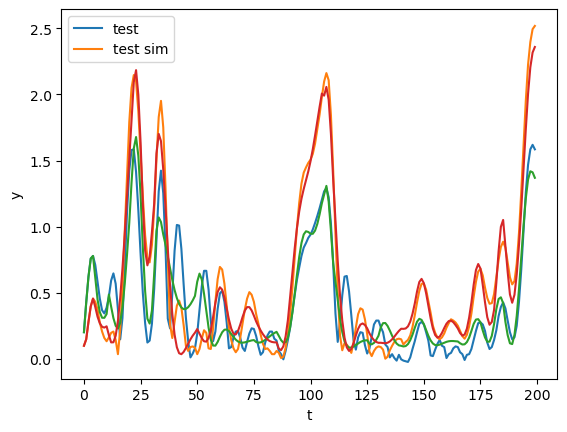

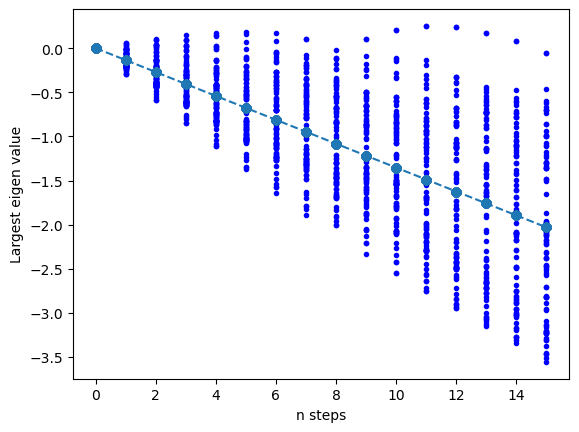

dt_lyapunov= -0.1353386080037923
dis_lyapunov= 0.8734201145697583
tau_dt= 7.388874577252776


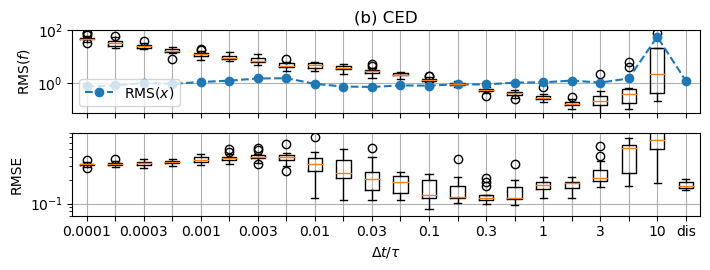

<ipython-input-12-08ec62d10308>:242: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([''])


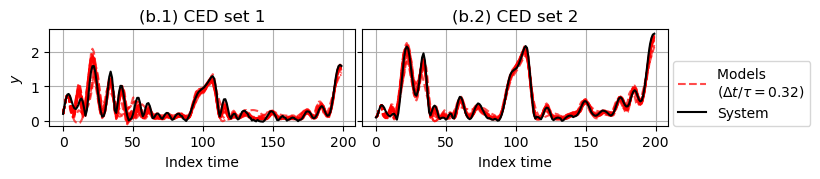

In [13]:
dataset = 'CED'
RMS_data,NRMS_data,ampx_data,ampf_data,names,dt_lyapunov,re_ordered, train, test, val = full_analysis(dataset,load=False)
box_plots(RMS_data,ampx_data,ampf_data,names,dt_lyapunov,dataset,ylims=[(0.07, 0.8), (0.07, 100)],title='(b) CED')
test_p_plot(names, RMS_data, re_ordered, test,dataset,title='(b) CED',xlim=(0, 400))

In [14]:
RMS_drive1 = []
RMS_drive2 = []
for k, item in re_ordered.items():
    RMS_drive1.append([ti['test_p'][0].RMS(test[0]) for ti in item])
    RMS_drive2.append([ti['test_p'][1].RMS(test[1]) for ti in item])

In [15]:
print('RMS test set 1')
print('dt/tau     mean,  std mean,     min')
print('\n'.join([f'{n:5.6} {np.median(r):9.4}±{np.std(r)/len(r)**0.5:9.4} {np.min(r):9.4} {len(r):5}' for n,r in zip(names,RMS_drive1)]))
print()

print('RMS test set 2')
print('dt/tau     mean,  std mean,     min')
print('\n'.join([f'{n:5.6} {np.median(r):9.4}±{np.std(r)/len(r)**0.5:9.4} {np.min(r):9.4}  {len(r):5}' for n,r in zip(names,RMS_drive2)]))

RMS test set 1
dt/tau     mean,  std mean,     min
0.0001    0.2812± 0.003959    0.2645    20
0.0001    0.2867± 0.004884    0.2561    20
0.0003    0.2909± 0.004289    0.2626    20
0.0005    0.3043± 0.005025    0.2659    19
0.0010    0.3131±  0.00703    0.2693    19
0.0017    0.3295± 0.009421     0.286    19
0.0031    0.3351± 0.009848    0.2618    19
0.0056    0.3316±   0.0149    0.2622    18
0.0100    0.3168±  0.02697    0.1385    18
0.0177    0.2646±  0.05705     0.126    18
0.0316    0.2144±   0.1024    0.1231    18
0.0562    0.2095±   0.0115    0.1234    18
0.1000    0.1455±  0.01063   0.09401    18
0.1778    0.1431±  0.01677    0.1146    18
0.3162    0.1435± 0.007456    0.1216    18
0.5623    0.1466±  0.01276    0.1177    18
1.0000    0.1887± 0.006625    0.1363    18
1.7782    0.1833± 0.006934     0.131    17
3.1622       nan±      nan       nan    17
5.6234    0.2229±  0.01874     0.157    17
10.000    0.4347±  0.03556    0.1681    17
dis      0.1866± 0.003138     0.169    20

RMS

  0%|          | 0/1102 [00:00<?, ?it/s]

./models-encoder-CT-CCT/con-0-0.00010-best ./models-encoder-CT-CCT/con-0-0.00018-best ./models-encoder-CT-CCT/con-0-0.00032-best ./models-encoder-CT-CCT/con-0-0.00056-best ./models-encoder-CT-CCT/con-0-0.00100-best ./models-encoder-CT-CCT/con-0-0.00178-best ./models-encoder-CT-CCT/con-0-0.00316-best ./models-encoder-CT-CCT/con-0-0.00562-best ./models-encoder-CT-CCT/con-0-0.01000-best ./models-encoder-CT-CCT/con-0-0.01778-best ./models-encoder-CT-CCT/con-0-0.03162-best ./models-encoder-CT-CCT/con-0-0.05623-best ./models-encoder-CT-CCT/con-0-0.10000-best ./models-encoder-CT-CCT/con-0-0.17783-best ./models-encoder-CT-CCT/con-0-0.31623-best ./models-encoder-CT-CCT/con-0-0.56234-best ./models-encoder-CT-CCT/con-0-1.00000-best ./models-encoder-CT-CCT/con-0-1.77828-best ./models-encoder-CT-CCT/con-0-10.00000-best 

<ipython-input-12-08ec62d10308>:49: RuntimeWarning: overflow encountered in square
  xamp = np.mean(np.mean(X**2,axis=1))**0.5 #np.mean(np.sum(X**2,axis=1)**0.5)
<ipython-input-12-08ec62d10308>:55: RuntimeWarning: overflow encountered in square
  d['|f|'] = np.mean(np.mean(fxu**2,axis=1))**0.5


./models-encoder-CT-CCT/con-0-3.16228-best ./models-encoder-CT-CCT/con-0-5.62341-best ./models-encoder-CT-CCT/con-1-0.00010-best ./models-encoder-CT-CCT/con-1-0.00018-best ./models-encoder-CT-CCT/con-1-0.00032-best ./models-encoder-CT-CCT/con-1-0.00056-best ./models-encoder-CT-CCT/con-1-0.00100-best ./models-encoder-CT-CCT/con-1-0.00178-best ./models-encoder-CT-CCT/con-1-0.00316-best ./models-encoder-CT-CCT/con-1-0.00562-best ./models-encoder-CT-CCT/con-1-0.01000-best ./models-encoder-CT-CCT/con-1-0.01778-best ./models-encoder-CT-CCT/con-1-0.03162-best ./models-encoder-CT-CCT/con-1-0.05623-best ./models-encoder-CT-CCT/con-1-0.10000-best ./models-encoder-CT-CCT/con-1-0.17783-best ./models-encoder-CT-CCT/con-1-0.31623-best ./models-encoder-CT-CCT/con-1-0.56234-best ./models-encoder-CT-CCT/con-1-1.00000-best ./models-encoder-CT-CCT/con-1-1.77828-best ./models-encoder-CT-CCT/con-1-10.00000-best ./models-encoder-CT-CCT/con-1-3.16228-best ./models-encoder-CT-CCT/con-1-5.62341-best ./models-e

./models-encoder-CT-CCT/con-40-1.77828-best ./models-encoder-CT-CCT/con-40-10.00000-best ./models-encoder-CT-CCT/con-40-3.16228-best ./models-encoder-CT-CCT/con-40-5.62341-best ./models-encoder-CT-CCT/con-41-0.00010-best ./models-encoder-CT-CCT/con-41-0.00018-best ./models-encoder-CT-CCT/con-41-0.00032-best ./models-encoder-CT-CCT/con-41-0.00056-best ./models-encoder-CT-CCT/con-41-0.00100-best ./models-encoder-CT-CCT/con-41-0.00178-best ./models-encoder-CT-CCT/con-41-0.00316-best ./models-encoder-CT-CCT/con-41-0.00562-best ./models-encoder-CT-CCT/con-41-0.01000-best ./models-encoder-CT-CCT/con-41-0.01778-best ./models-encoder-CT-CCT/con-41-0.03162-best ./models-encoder-CT-CCT/con-41-0.05623-best ./models-encoder-CT-CCT/con-41-0.10000-best ./models-encoder-CT-CCT/con-41-0.17783-best ./models-encoder-CT-CCT/con-41-0.31623-best ./models-encoder-CT-CCT/con-41-0.56234-best ./models-encoder-CT-CCT/con-41-1.00000-best ./models-encoder-CT-CCT/con-41-1.77828-best ./models-encoder-CT-CCT/con-41-

D:\Programs\anaconda3\lib\site-packages\numpy\core\_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


./models-encoder-CT-CCT/con-44-3.16228-best ./models-encoder-CT-CCT/con-44-5.62341-best ./models-encoder-CT-CCT/con-45-0.00010-best ./models-encoder-CT-CCT/con-45-0.00018-best ./models-encoder-CT-CCT/con-45-0.00032-best ./models-encoder-CT-CCT/con-45-0.00056-best ./models-encoder-CT-CCT/con-45-0.00100-best ./models-encoder-CT-CCT/con-45-0.00178-best ./models-encoder-CT-CCT/con-45-0.00316-best ./models-encoder-CT-CCT/con-45-0.00562-best ./models-encoder-CT-CCT/con-45-0.01000-best ./models-encoder-CT-CCT/con-45-0.01778-best ./models-encoder-CT-CCT/con-45-0.03162-best ./models-encoder-CT-CCT/con-45-0.05623-best ./models-encoder-CT-CCT/con-45-0.10000-best ./models-encoder-CT-CCT/con-45-0.17783-best ./models-encoder-CT-CCT/con-45-0.31623-best ./models-encoder-CT-CCT/con-45-0.56234-best ./models-encoder-CT-CCT/con-45-1.00000-best ./models-encoder-CT-CCT/con-45-1.77828-best ./models-encoder-CT-CCT/con-45-3.16228-best ./models-encoder-CT-CCT/con-45-5.62341-best ./models-encoder-CT-CCT/con-5-0.

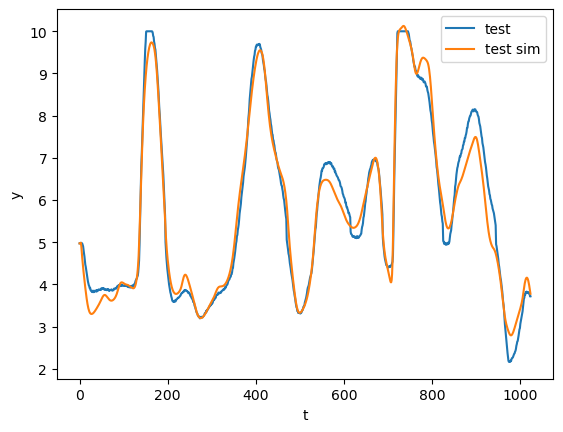

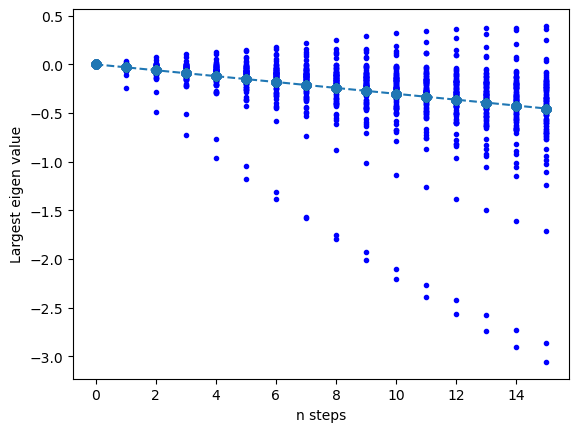

dt_lyapunov= -0.030270862800681683
dis_lyapunov= 0.9701827115493404
tau_dt= 33.03506763531961


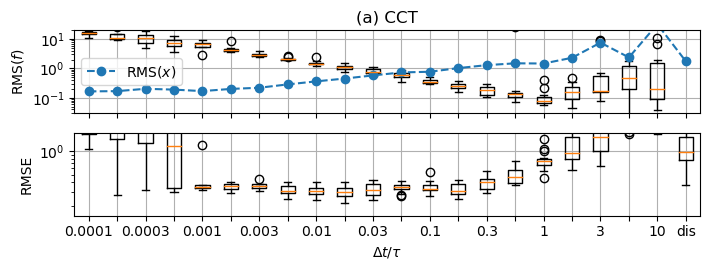

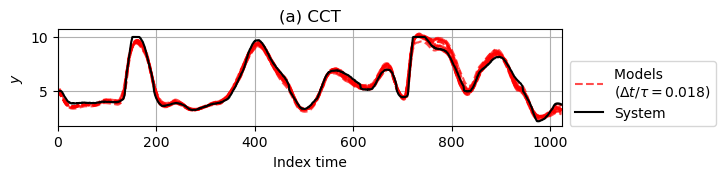

In [17]:
dataset = 'CCT'
RMS_data,NRMS_data,ampx_data,ampf_data,names,dt_lyapunov,re_ordered,train, test, val = full_analysis('CCT',load=False)
box_plots(RMS_data,ampx_data,ampf_data,names,dt_lyapunov,dataset,ylims=([0.15,1.7],[0.03,20]),title='(a) CCT')
test_p_plot(names, RMS_data, re_ordered, test,dataset,xlim=(0,1024),title='(a) CCT')

In [8]:
print('RMS CCT')
print('dt/tau     mean,  std mean,     min,    N models')
print('\n'.join([f'{n:5.6} {np.median(r):9.4}±{np.std(r)/len(r)**0.5:9.4} {np.min(r):9.4} {len(r):5}' for n,r in zip(names,RMS_data)]))
print()

RMS CCT
dt/tau     mean,  std mean,     min
0.0001     2.043±   0.2031     1.054    18
0.0001     2.388±   0.3529    0.2788    17
0.0003     1.798±   0.3355     0.318    17
0.0005     1.169±   0.4055    0.2991    17
0.0010      0.35±   0.1803    0.3193    17
0.0017    0.3599± 0.006658    0.2933    17
0.0031    0.3546± 0.007292    0.3069    17
0.0056     0.313±  0.01056    0.2429    17
0.0100    0.3078±   0.0104     0.236    17
0.0177    0.2985±  0.01203    0.2172    17
0.0316    0.3199±  0.01347    0.2361    17
0.0562    0.3524± 0.009465    0.2646    17
0.1000    0.3325±  0.01463    0.2668    17
0.1778    0.3103±  0.01504    0.2442    16
0.3162    0.4088±4.059e+03    0.2913    16
0.5623    0.4644±    0.195    0.3678    16
1.0000    0.7557±  0.05417    0.4585    16
1.7782    0.9501±1.349e+15    0.5698    16
3.1622     1.523±   0.5322    0.6358    16
5.6234     2.114±  0.04307     1.661    16
10.000     2.219±   0.9579     1.647    15
dis      0.9709±   0.1017     0.374    18

